> Đorđe Mirosavić E2 34/2023

# Problem lavirinta



## Imports

In [ ]:
from enum import Enum
from dataclasses import dataclass, astuple

from typing import Iterable
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange

import copy
import math
from PIL import Image

import seaborn as sns

In [ ]:
from abc import ABC, abstractmethod

## Parameters

In [ ]:
''' Defining the number of each obstacles'''
NUMBER_OF_TRAPS           = 6
NUMBER_OF_TERMINALS       = 2
NUMBER_OF_ADDED_WALLS     = 4
NUMBER_OF_ADDED_TELEPORTS = 2

''' Number of points that we get if steping on terminal or trap cell'''
REWARD_TERMINAL   = 0
REWARD_TRAP       = -5
REWARD_TELEPORT   = 0
REWARD_REGULAR    = -1

''' Defining color for each obstacle coded in hex value'''
COLOUR_REGULAR      = "#ffffff"     # white
COLOUR_WALL         = "#A1A2A6"     # grey
COLOUR_PLAYER       = "#14328C"     # blue
COLOUR_TERMINAL     = "#3CA66A"     # green
COLOUR_TRAP         = "#D92E1E"     # red
COLOUR_TELEPORT     = "#F2B84B"     # yellow
COLOUR_TELEPORT_TO  = "#F2D091"     # brighter yellow

## Classes

In [ ]:
class Action(Enum):
    """Labyrinth actions."""
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3
    STAY = 4

    def __repr__(self):
      match(self):
        case Action.UP: return "UP"
        case Action.RIGHT: return "RIGHT"
        case Action.DOWN: return "DOWN"
        case Action.LEFT: return "LEFT"
        case Action.STAY: return "STAY"
        case _: return "ERROR"

In [ ]:
class Cell(ABC):
    '''Base class for everuy cell.'''
    @abstractmethod
    def get_reward(self) -> float:
        pass

In [ ]:
class RegularCell(Cell):
    """A class that implements a regular cell - regular cells."""

    def __init__(self, reward: float):
        """Initialize the reward which player recieves when she/he steps on it.

        Args:
            reward (float): Defines the cost/reward of the cell.
        """
        self.reward = reward

    def get_reward(self) -> float:
        """Returns the reward from the cell.

        Returns:
            float: The recieved reward.
        """
        return self.reward

In [ ]:
class TrapCell(Cell):
    """A class that implements a trap cell - trap cells."""

    def __init__(self, reward: float):
        """Initialize the reward which player recieves when she/he steps on it.

        Args:
            reward (float): Defines the cost/reward of the cell.
        """
        self.reward = reward

    def get_reward(self) -> float:
        """Returns the reward from the cell.

        Returns:
            float: The recieved reward.
        """
        return self.reward

In [ ]:
class TerminalCell(Cell):
    """A class that implements a terminal cell."""

    def __init__(self, reward: float):
        """Initialize the reward which player recieves when she/he steps on it.

        Args:
            reward (float): Defines the cost/reward of the cell.
        """
        self.reward = reward

    def get_reward(self) -> float:
        """Returns the reward from the cell.

        Returns:
            float: The recieved reward.
        """
        return self.reward

In [ ]:
class TeleportCell():
  """A class that implements a teleport cell."""
  def __init__(self, reward: float, to_pos_x: int, to_pos_y: int):
        """Initialize the reward which player recieves when she/he steps on it.

        Args:
            reward (float): Defines the cost/reward of the cell.
            to_pos_x (int): Defines the x coordinate that teleport points to.
            to_pos_y (int): Defines the y coordinate that teleport points to.
        """
        self.reward = reward
        self.to_pos_x = to_pos_x
        self.to_pos_y = to_pos_y

  def get_reward(self) -> float:
        """Returns the reward from the cell.

        Returns:
            float: The recieved reward.
        """
        return self.reward

In [ ]:
class WallCell(Cell):
    """A class that implements a wall cell."""

    def __init__(self, reward: float):
        """Initialize the reward which player recieves when she/he steps on it.

        Args:
            reward (float): Defines the cost/reward of the cell.
        """
        self.reward = reward

    def get_reward(self) -> float:
        """Returns the reward from the cell.

        Returns:
            float: The recieved reward that player would never recieves.
        """
        return self.reward

In [ ]:
class Player():
  def __init__(self, positionX: int, positionY: int, points=0):
      """Initialize the player.

      Args:
          positionX (int): Current position of the player on the x axis.
          positionY (int): Current position of the player on the y axis, starting from the top side of the table.
          points (int): Storing total reward throught game.

      """
      self.positionX = positionX
      self.positionY = positionY
      self.points = points

In [ ]:
class Board():
    def __init__(self, rows: int,
                 columns: int,
                 initial_player_x: int,
                 initial_player_y: int,
                 initial_player_points = 0,
                 regular_cell_reward = REWARD_REGULAR):
        """Initialize the board on which player/agent explores labyrinth.

        Args:
            rows (int): Defines the number of board rows.
            columns (int): Defines the number of board columns.
            initial_player_x (int): Defines the initial position of a player - x coordinate.
            initial_plyer_y (int): Defines the initial position of a player - y coordinate.
            initial_player_points (int): Defines the starting points that player has.
            actions (list): Defines the actions player can make.
        """
        self.rows = rows
        self.columns = columns
        self.player_x = initial_player_x
        self.player_y = initial_player_y
        self.player_points = initial_player_points
        self.actions = [a for a in Action]
        self.game_over = False

        self.state_list = []
        self.teleport_cells_dict = {}

        # for stohastic value iteration
        self.actions_probability = [[{} for _ in range(columns)] for _ in range(rows)]

        # Represent blank cells
        self.numbers = list(range((self.rows)*(self.columns)))

        # problem pravi ako se pozove addTerminalRandomly i ispostavi se da se igrac nalazi na toj poziciji

        ''' For every cell we define the probability of each action.
            For example: For every move player makes, there is 20% chance that we will have a wind
            that will displace player one cell to the right. If we want to model that, we can form dictionary
            that can store out move and it's probability of happening. For the case where action is UP, our key
            will be "UP", and the value(probability) will be [0.8 0.2 0 0]. Probability list is formed in such a way
            that action index match the probability index. For moving to the LEFT, key="LEFT", value=[0 0.2 0 0.8]'''

        for i in range(self.rows):
          for j in range(self.columns):
            self.actions_probability[i][j] = {a:[0, 0, 0, 0, 0] for a in self.actions}

        ''' We form matrix that has dimensions rows*columns where every cell is a RegularCell
        '''

        self.board = [[RegularCell(regular_cell_reward) for i in range(columns)] for j in range(rows)]

        for i in range(self.rows):
          for j in range(self.columns):

            ''' Wall cells are located in the outer ring of the matrix
            '''
            if i==0 or i==self.rows-1 or j==0 or j==self.columns-1:
              self.board[i][j] = WallCell(1)

              ''' Now we discard number corensponding to this cell, so that we can no longer place other cell shere
              '''
              selected_number = j + (self.columns)*i
              self.numbers.remove(selected_number)

            ''' Adding action probabilites for regular cells
            '''
            if i>=1 and i<self.rows-1 and j>=1 and j<self.columns-1:
              ''' We assumed that actions are UP,RIGHT,DOWN,LEFT,STAY ,in this order
                  And we add 'wind' that will push player one cell to the right in 30% of situations'''
              self.actions_probability[i][j][Action.UP] = [0.7,0.3,0,0,0]
              self.actions_probability[i][j][Action.RIGHT] = [0,1,0,0,0]
              self.actions_probability[i][j][Action.DOWN] = [0,0.3,0.7,0,0]
              self.actions_probability[i][j][Action.LEFT] = [0,0,0,0.7,0.3]
              self.actions_probability[i][j][Action.STAY] = [0,0.3,0,0,0.7]

    def change_cell(self, pos_x: int, pos_y: int, cell_type: Cell):
        ''' Changing the type of the cell on the position (pos_x, pos_y)
        '''
        self.board[pos_y][pos_x] = cell_type

    def addPlayerRandomly(self):
        ''' Method that randomly place player on the map.
        '''
        selected_number = random.choice(self.numbers)
        rand_player_y, rand_player_x = divmod(selected_number, (self.columns))
        self.numbers.remove(selected_number)
        self.move_player(rand_player_x, rand_player_y)

    def addTerminal(self, pos_x: int, pos_y:int, reward:int, override_cell = False):
        ''' Adding terminal cell on position (pos_x, pos_y) with specified reward.
        When parameter override_cell is True, then we can place terminal cell on occupied cell (trap, wall, teleport)
        '''
        selected_number = pos_x + (self.rows)*pos_y
        try:
          self.numbers.remove(selected_number)  # ako ovde pukne to znaci da tu vec ima nesto
          self.change_cell(pos_x, pos_y, TerminalCell(reward))
        except:
          if override_cell == True:
            self.change_cell(pos_x, pos_y, TerminalCell(reward))

    def addTeleport(self, reward:int, pos_x:int, pos_y:int, to_pos_x:int, to_pos_y:int, override_cell = False):
        ''' Method that adds teleport to desired position (pos_x, pos_y).
        We can also override that cell if there is something on it
        '''

        # TODO uraditi proveru da li moze da se postavi tu teleport i tako to

        selected_number = pos_x + (self.rows)*pos_y

        try:
          self.numbers.remove(selected_number)  # ako ovde pukne to znaci da tu vec ima nesto
          teleport_reward = self.board[to_pos_y][to_pos_x].get_reward()
          self.change_cell(pos_x, pos_y, TeleportCell(teleport_reward, to_pos_x, to_pos_y))
          self.teleport_cells_dict[(pos_x,pos_y)] = (to_pos_x, to_pos_y)
        except:
          if override_cell == True:
            teleport_reward = self.board[to_pos_y][to_pos_x].get_reward()
            self.change_cell(pos_x, pos_y, TeleportCell(teleport_reward, to_pos_x, to_pos_y))
            self.teleport_cells_dict[(pos_x,pos_y)] = (to_pos_x, to_pos_y)

    def addTeleportRandomly(self, reward:int):
        selected_number = random.choice(self.numbers)
        pos_y, pos_x = divmod(selected_number, (self.columns))
        self.numbers.remove(selected_number)

        second_selected_number = random.choice(self.numbers)
        to_pos_y, to_pos_x = divmod(second_selected_number, (self.columns))
        self.numbers.remove(second_selected_number)

        teleport_reward = self.board[to_pos_y][to_pos_x].get_reward()
        self.change_cell(pos_x, pos_y, TeleportCell(teleport_reward, to_pos_x, to_pos_y))
        self.teleport_cells_dict[(pos_x,pos_y)] = (to_pos_x, to_pos_y)



    def addTerminalRandomly(self, reward: int):
        ''' Method that randomly place terminal cell with specified reward.
        '''
        selected_number = random.choice(self.numbers)
        terminal_y, terminal_x = divmod(selected_number, (self.columns))
        self.change_cell(terminal_x, terminal_y, TerminalCell(reward))

        self.numbers.remove(selected_number)

    def addTrapRandomly(self, reward: int):
        ''' Method that randomly place trap cell with specified reward.
        '''
        selected_number = random.choice(self.numbers)
        terminal_y, terminal_x = divmod(selected_number, (self.columns))
        self.numbers.remove(selected_number)
        self.change_cell(terminal_x, terminal_y, TrapCell(reward))

    def addWallRandomly(self, reward=0):
        ''' Method that randomly place wall cell.
        '''
        selected_number = random.choice(self.numbers)
        terminal_y, terminal_x = divmod(selected_number, (self.columns))
        self.numbers.remove(selected_number)
        self.change_cell(terminal_x, terminal_y, WallCell(reward))

    def get_board(self):
      """ Returns the board matrix with cells."""
      return self.board

    def get_points(self):
      """ Returns the current points that player has."""
      return self.player_points

    def get_actions(self):
      return self.actions

    def get_current_cell_reward(self):
      """ Returns reward of the current cell where is player. """
      return self.board[self.player_y][self.player_x].get_reward()

    def get_actions_probability(self) -> dict:
      """ For each state, returns the probability of applying each action """
      action_dict = {}
      for i in range(self.rows):
          for j in range(self.columns):
            if not isinstance(self.board[i][j], WallCell):
              action_dict[(j,i)] = self.actions_probability[i][j]
      return action_dict

    def get_current_state_list(self) -> list:
      """ Returns the list of states."""
      return self.state_list

    def get_state_list(self)->list[tuple[int, int]]:
      """ Returns the list of all states in a list."""
      for i in range(self.rows):
          for j in range(self.columns):
            if not isinstance(self.board[i][j], WallCell):
              self.state_list.append((j, i))    # (x,y) tuple
      return self.state_list

    def get_state_list_stohastic(self) -> list[tuple[int, int], list]:
      """ Returns the list of player position and probability of applying each action
      """
      for i in range(self.rows):
          for j in range(self.columns):
            if not isinstance(self.board[i][j], WallCell):
              self.state_list.append([(j, i), self.actions_probability[i][j]]) # (x,y) tuple + probability for each action
      return self.state_list

    def update_points(self):
        ''' Updating current poins that player has with cell reward on his current position.'''
        self.player_points = self.player_points + self.board[self.player_y][self.player_x].get_reward()

    def move_player_by_action(self, action: Action) -> bool:
      """
        For given action, moves player to correnspoding cell
      """
      match action:
        case Action.UP:
          is_moved = self.move_player(self.player_x, self.player_y - 1)
        case Action.RIGHT:
          is_moved = self.move_player(self.player_x + 1, self.player_y)
        case Action.DOWN:
          is_moved = self.move_player(self.player_x, self.player_y + 1)
        case Action.LEFT:
          is_moved = self.move_player(self.player_x - 1, self.player_y)
        case Action.STAY:
          is_moved = self.move_player(self.player_x, self.player_y)
        case _:
          raise ValueError(f"Action ({action}) is invalid.")
      return is_moved

    def move_player(self, pos_x: int, pos_y: int) -> bool:
        """
          Move player to position (pos_x, pos_y). Can call itself it we step into teleport cell.
          Return indicator if player position is changed.
        """

        '''
          Promenili smo redosled tako da prvo pitamo da li je trenutna celija teleport
          Ako jeste onda ulazimo u teleport, a ne da odmah vratimo False ako je pos_x==self.player_x
        '''
        if isinstance(self.board[pos_y][pos_x], TeleportCell):
          self.move_player(self.board[pos_y][pos_x].to_pos_x, self.board[pos_y][pos_x].to_pos_y)
          return True

        ''' Moves player to the (pos_x, pos_y) if it's not a wall.'''
        if pos_x==self.player_x and pos_y==self.player_y:
          ''' We are staying in place'''
          return False

        if not isinstance(self.board[pos_y][pos_x], WallCell):
          self.player_x = pos_x
          self.player_y = pos_y
          return True
        return False

    def is_game_over(self):
        ''' Checking if player is standing on a terminal cell. If it is, than that's the players wins.'''
        if isinstance(self.board[self.player_y][self.player_x], TerminalCell):
          self.game_over = True;
        return self.game_over

    def is_cell_terminal(self):
        ''' Checking if current cell is terminal.'''
        if isinstance(self.board[self.player_y][self.player_x], TerminalCell):
          return True
        else:
          return False

    def move_player_stohactic(self, probabilities):
      probabilities_cumsum = np.cumsum(probabilities)
      rand_number = random.random()

      action_index=0
      ''' Because index of action and probabilities match each other, we can only save
          index and after loop we can read what action we have to apply'''
      for p in probabilities_cumsum:
        if rand_number<p:
          break
        action_index = action_index + 1
      a = self.actions[action_index]

      is_moved = self.move_player_by_action(a)

      return is_moved

    def move_none(self):
        ''' We stay in place'''
        is_moved = self.move_player(self.player_x, self.player_y)
        return is_moved

    def move_up(self):
        ''' Moving player one cell up.'''
        is_moved = self.move_player(self.player_x, self.player_y - 1)
        self.update_points()
        self.is_game_over()
        return is_moved

    def move_down(self):
        ''' Moving player one cell down.'''
        is_moved = self.move_player(self.player_x, self.player_y + 1)
        self.update_points()
        self.is_game_over()
        return is_moved

    def move_left(self):
        ''' Moving player one cell left.'''
        is_moved = self.move_player(self.player_x - 1, self.player_y)
        self.update_points()
        self.is_game_over()
        return is_moved

    def move_right(self):
        ''' Moving player one cell right.'''
        is_moved = self.move_player(self.player_x + 1, self.player_y)
        self.update_points()
        self.is_game_over()
        return is_moved


## Helper functions

In [ ]:
def showBoardWithGrid(board,
                      teleport_cells_dict = None):
  ''' Showing board with grid. '''
  plt.pcolormesh(board, edgecolors='k', linewidth=2)
  plt.text(Tabla.player_x + 0.5, Tabla.player_y + 0.5,  "и", fontsize=30, ha = 'center', va = 'center')


  # Printing teleport from(f) and to(t)
  for index, key in enumerate(teleport_cells_dict):
    x, y = key
    to_x, to_y = teleport_cells_dict[key]
    plt.text(x + 0.5, y + 0.5, f"f{index}", fontsize=15, ha = 'center', va = 'center')
    plt.text(to_x + 0.5, to_y + 0.5, f"t{index}", fontsize=15, ha = 'center', va = 'center')

  ax = plt.gca()
  ax.set_aspect('equal')
  ax.invert_yaxis()

In [ ]:
def showBoardWithGridAndScores(board,
                               columns: int,
                               rows: int,
                               values: dict,
                               show_text: bool,
                               teleport_cells_dict,
                               show_teleport: bool):
  ''' Showing board with grid and scores within the cell.'''
  scale = max(rows, columns)    # we try to scale board regarding dimensions

  plt.figure(figsize=(scale/2, scale/2))
  plt.pcolormesh(board, edgecolors='k', linewidth=2)

  for state in values:
    if show_text is True:
      plt.text(state[0] + 0.5, state[1] + 0.7,  f"{values[state]:.1f}", fontsize=10, ha = 'center', va = 'center')

  if show_teleport is True:
    # Printing teleport from(f) and to(t)
    for index, key in enumerate(teleport_cells_dict):
      from_x, from_y = key
      to_x, to_y = teleport_cells_dict[key]
      plt.text(from_x + 0.5, from_y + 0.3, f"f{index}", fontsize=10, ha = 'center', va = 'center')
      plt.text(to_x + 0.5, to_y + 0.3, f"t{index}", fontsize=10, ha = 'center', va = 'center')

  ax = plt.gca()
  ax.set_aspect('equal')
  ax.invert_yaxis()

In [ ]:
def refreshBoard(board):
  ''' Refresing the board with new player position.'''
  new_board = copy.deepcopy(board)
  # bojenje igraca u plavo new_board[Tabla.player_y][Tabla.player_x] = hex_to_rgb(COLOUR_PLAYER)
  return new_board

In [ ]:
def hex_to_rgb(hex_value):
    ''' Function that gives rbg code from hex value.'''
    value = hex_value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

In [ ]:
def parse_text_to_action(text)->Action:
  """ Returns Action for given string input """
  match(str.lower(text)):
    case 'up': return Action.UP
    case 'right': return Action.RIGHT
    case 'down': return Action.DOWN
    case 'left': return Action.LEFT
    case 'stay': return Action.STAY
    case _: return Action.STAY


## Generating board

In [ ]:
def generate_map(rows: int, columns: int):
  Tabla = Board(rows, columns, 1, 1)
  Tabla.addPlayerRandomly()
  for _ in range(NUMBER_OF_TERMINALS):
    Tabla.addTerminalRandomly(REWARD_TERMINAL)
  for _ in range(NUMBER_OF_ADDED_TELEPORTS):
    Tabla.addTeleportRandomly(REWARD_TELEPORT)
  for _ in range(NUMBER_OF_TRAPS):
    Tabla.addTrapRandomly(REWARD_TRAP)
  for _ in range(NUMBER_OF_ADDED_WALLS):
    Tabla.addWallRandomly()

  slika = Tabla.get_board()

  board = np.ones(shape=(rows, columns, 3), dtype=np.uint8)
  ''' Coloring the squares accordion to cells.'''
  for i in range(rows):
    for j in range(columns):
      if isinstance(slika[i][j], RegularCell):
        # Red Green Blue format
        board[i,j,:] = hex_to_rgb(COLOUR_REGULAR)
      else:
        if isinstance(slika[i][j], WallCell):
          board[i,j,:] = hex_to_rgb(COLOUR_WALL)
        else:
          if isinstance(slika[i][j], TerminalCell):
            board[i,j,:] = hex_to_rgb(COLOUR_TERMINAL)
          else:
            if isinstance(slika[i][j], TrapCell):
              board[i,j,:] = hex_to_rgb(COLOUR_TRAP)
  # Color teleport cells
  for key, value in Tabla.teleport_cells_dict.items():
    j, i = key
    teleported_j, teleported_i = value
    board[i,j,:] = hex_to_rgb(COLOUR_TELEPORT)
    board[teleported_i,teleported_j,:] = hex_to_rgb(COLOUR_TELEPORT_TO)
  return Tabla, board

In [ ]:
Tabla, board = generate_map(10,10)

## Playing the game manually

Player current points: 0
Current action probabilities: [0.7, 0.3, 0, 0, 0]
Does i moved: False, is terminal = False, and this cell costs -1


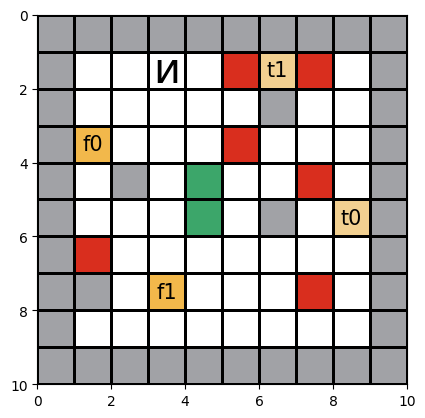

In [ ]:
direction_input = 'UP' # @param ['UP', 'RIGHT', 'DOWN', 'LEFT', 'STAY']
# ovo su nam akcije koje nas agent moze da koristi, i moraju da budu unutar ' ',
# ne mogu da stoje izmedju ""


action = parse_text_to_action(direction_input)
act_prob = Tabla.get_actions_probability()

if action==Action.STAY:
  p=[1,0,0,0,0]
else:
  p=act_prob[(Tabla.player_x,Tabla.player_y)][action]

is_moved = Tabla.move_player_stohactic(p)

showBoardWithGrid(refreshBoard(board),
                  Tabla.teleport_cells_dict)
print(f"Player current points: {Tabla.get_points()}")
print(f"Current action probabilities: {p}")
print(f"Does i moved: {is_moved}, is terminal = {Tabla.is_cell_terminal()}, and this cell costs {Tabla.get_current_cell_reward()}")

## Implementing algorithm

#### Get states to list from board (stohastic case)

In [ ]:
states_list = Tabla.get_state_list()

values = {s: random.random() for s in states_list}

for s in values:
    if isinstance(Tabla.board[s[1]][s[0]], TerminalCell):
        values[s] = 0

""" Defining probability of applying each action. """
action_prob_list = Tabla.get_actions_probability()


#### Implementacija algoritma



In [ ]:
def compute_v(player_x: int, player_y: int, values, gamma: float):
  """
    Idea is to go to next cell, check the rewards of that cell and then update values based on that.
    We are finding next best cell where we can step.
  """
  rhs = []
  for a in [a.value for a in Action]:
      Tabla.player_x = player_x;
      Tabla.player_y = player_y;
      Tabla.move_none()         # we try to step into this cell because it can be a teleport cell
      r = Tabla.get_current_cell_reward()

      Tabla.move_player_by_action(a)

      rhs.append( r + gamma*values[(Tabla.player_x, Tabla.player_y)] )
  return max(rhs)

In [ ]:
def iteration_by_value(number_of_iterations: int, gamma: float, values):
  """ For each player state, compute next value of that state"""
  for _ in range(number_of_iterations):
    for s in values:
      Tabla.player_x = s[0];
      Tabla.player_y = s[1];

      if not Tabla.is_cell_terminal():
        values[s] = compute_v(s[0], s[1], values, gamma)
  return values

In [ ]:
def compute_v_stohastic(player_x: int, player_y: int, values, actions_probabilities, gamma: float):
  rhs = []

  a_probability = actions_probabilities[(player_x, player_y)]
  'We extract the actions and their probabilites'

  actions = Tabla.get_actions()

  for a in a_probability:
      Tabla.player_x = player_x;
      Tabla.player_y = player_y;

      p = a_probability[a]
      'Here we get probabilites, and this is enough to move a player/agent'


      sum = 0
      for a in actions:
        Tabla.player_x = player_x;
        Tabla.player_y = player_y;

        Tabla.move_player_by_action(a)
        r = Tabla.get_current_cell_reward()

        sum = sum + p[actions.index(a)] *(r + gamma*values[(Tabla.player_x, Tabla.player_y)])

      rhs.append( sum )
  return max(rhs)

In [ ]:
def iteration_by_value_stohastic(number_of_iterations, gamma, values, actions_probabilities):
  for _ in range(number_of_iterations):
    for s in values:
      Tabla.player_x = s[0];
      Tabla.player_y = s[1];

      if not Tabla.is_cell_terminal():
        values[s] = compute_v_stohastic(s[0], s[1], values, actions_probabilities, gamma)
  return values

# Simulating system

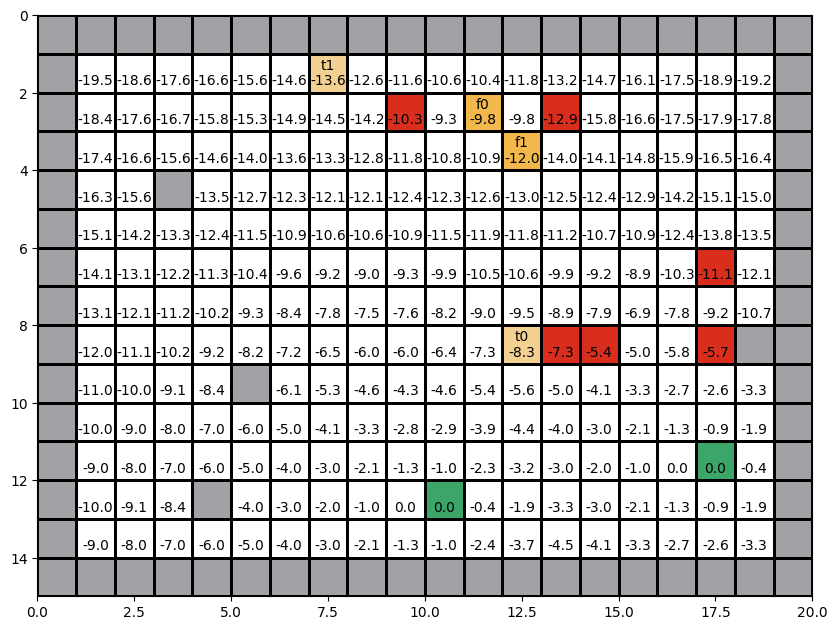

In [ ]:
# @title Game simulation {"display-mode":"form"}
generate_new_board = True # @param {type:"boolean"}

ROWS_NUMBER = 15 # @param {type:"integer"}
COLUMNS_NUMBER = 20 # @param {type:"integer"}

number_of_iterations = 100 # @param {type:"slider", min:1, max:200, step:1}
gamma = 1 # @param {type:"slider", min:0, max:1, step:0.1}


show_values = True # @param {type:"boolean"}

rightside_wind = True # @param {"type":"boolean"}


if generate_new_board == True:
  Tabla, board = generate_map(ROWS_NUMBER, COLUMNS_NUMBER)

states_list = Tabla.get_state_list()
values = {s: random.random() for s in states_list}


for s in values:
    if isinstance(Tabla.board[s[1]][s[0]], TerminalCell):
        values[s] = REWARD_TERMINAL # U slucaju da dobijamo nesto ako se zakucamo u terminal
actions_prob_list = Tabla.get_actions_probability()

if rightside_wind is True:
  v = iteration_by_value_stohastic(number_of_iterations, gamma, values, actions_prob_list)
else:
  v = iteration_by_value(number_of_iterations, gamma, values)

showBoardWithGridAndScores(refreshBoard(board),
                           COLUMNS_NUMBER,
                           ROWS_NUMBER,
                           v,
                           show_values,
                           Tabla.teleport_cells_dict,
                           True)


#### Drawing functions and greedy algorithm

In [ ]:
def greedy_action(Tabla, s, values, gamma):
  """
    Returns the index of greedy action
  """
  vs = []
  x0 = s[0]
  y0 = s[1]
  for a in Tabla.get_actions():
    Tabla.player_x = x0;
    Tabla.player_y = y0;
    r = Tabla.get_current_cell_reward()

    Tabla.move_player_by_action(a)
    s_next = (Tabla.player_x, Tabla.player_y)
    vs.append(r + gamma*values[s_next])
  return np.argmax(vs)

In [ ]:
def action_symbol(a:Action):
  """
    Returns the symbol that coresponds to action
  """
  match(a):
    case Action.UP: return '↑'
    case Action.RIGHT: return '→'
    case Action.DOWN: return '↓'
    case Action.LEFT: return '←'
    case Action.STAY: return '•'
    case _: return '?'

In [ ]:
def display_heatmap(values,
                    show_values = False,
                    decimals = 0):
  """
    Returns 2D heatmap for value iteration method
  Args:
    values: Value dictionary of each state
    show_values: Indicator whether we want to show values inside the cell
    decimals: how many decimal places of each value will we displayed
  """


  '''
    Nan values that will be stored in matrix after the loop will be wall cells
  '''
  matrix = np.nan*np.ones((ROWS_NUMBER, COLUMNS_NUMBER))

  """
    State values are in the matrix
  """
  for state in values:
    x = state[0]
    y = state[1]
    matrix[y][x] = round(values[state], decimals)

  """
    Choose color scheme
  """
  # cmap = sns.color_palette("Blues", as_cmap=True)
  # cmap = sns.color_palette("vlag", as_cmap=True)
  # cmap = sns.color_palette("coolwarm", as_cmap=True)
  cmap = sns.color_palette(palette='RdYlGn', as_cmap=True)
  #cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
  #cmap.set_under(".9")
  plt.figure(figsize=(ROWS_NUMBER/2, COLUMNS_NUMBER/2))

  sns.heatmap(matrix,
              cmap=cmap,
              linewidths=0.3,
              linecolor="white",
              mask=np.isnan(matrix),
              cbar_kws={"shrink": .5},
              vmax=0,
              annot=show_values)

  ax = plt.gca()
  ax.set_aspect('equal')
  plt.title("Heatmap of q values, greener is better")

# Drawing optimal path and heatmap

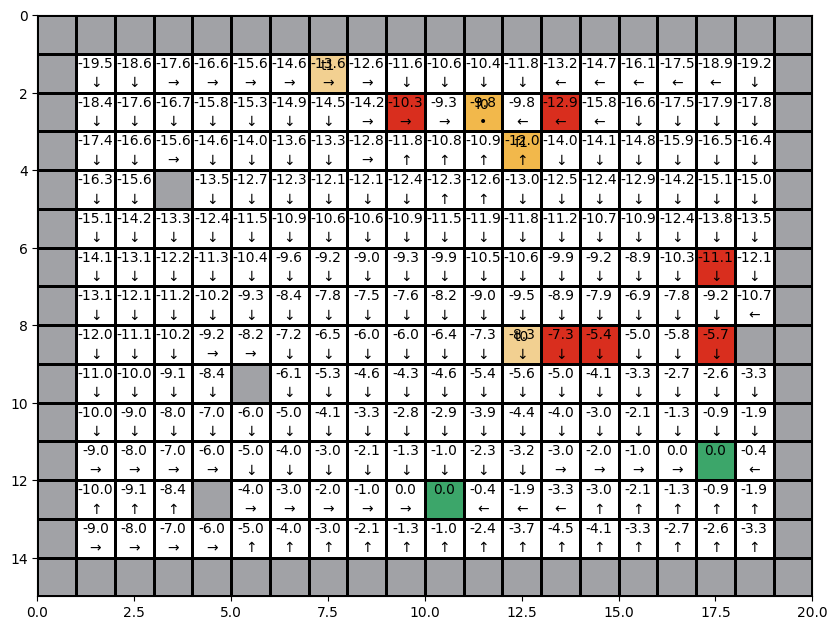

In [ ]:
# @title
# @title  {"display-mode":"form"}
show_arrows = True # @param {type:"boolean"}
show_values = True # @param {type:"boolean"}

showBoardWithGridAndScores(refreshBoard(board),
                           COLUMNS_NUMBER,
                           ROWS_NUMBER,
                           v,
                           False,
                           Tabla.teleport_cells_dict,
                           True)
arrows_dict = {}
for s in states_list:
  index = greedy_action(Tabla, s, v, 1)
  symbol = action_symbol(Tabla.get_actions()[index])
  if isinstance(Tabla.board[s[1]][s[0]], TerminalCell):
    symbol = ''
  if show_arrows:
    plt.text(s[0]+0.5,s[1]+0.75, symbol, fontsize=10, ha = 'center', va = 'center')
  if show_values:
    plt.text(s[0]+0.5,s[1]+0.25, f"{v[s]:.1f}", fontsize=10, ha = 'center', va = 'center')

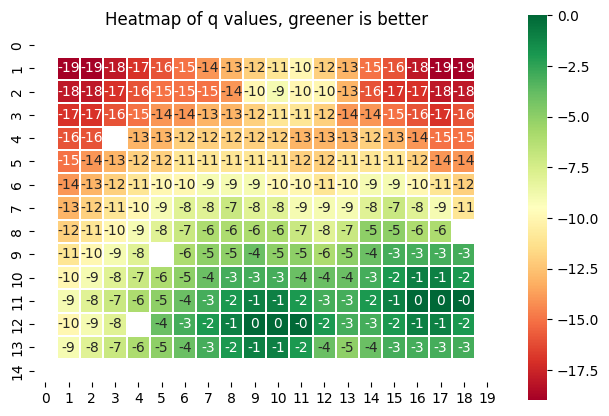

In [ ]:
show_values = True # @param {"type":"boolean"}

display_heatmap(v, show_values=show_values, decimals=0)